Lets import library and load our Data. Also we are removing those rows having NA values in any of its corresponding column. We will also remove instances where unit price is zero and quantity purchased is less than zero.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

df=pd.read_csv("Retail.csv",encoding='iso-8859-1')
df=df.dropna(axis=0)
df=df.drop(df.loc[df.UnitPrice==0,].index)
df=df.drop(df.loc[df.Quantity<0,].index)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


Invoice number is misleading, there are multiple invoiceNo for same customerID, without differeing much in time of purchase, hence we can remove invoiceNo.
Also removing description column as we have stockcode as its proxy.

In [2]:
df.drop(['InvoiceNo','Description'],axis=1,inplace=True)
df.shape

(397884, 6)

Lets process InvoiceDate and break it into day of week, month, and year.

In [3]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format='%d-%m-%Y %H:%M')

def process_date(data):
    data['Day'] = data['InvoiceDate'].dt.dayofweek # The day of the week with Monday=0, Sunday=6
    data['Month'] = data['InvoiceDate'].dt.month
    data['Year'] = data['InvoiceDate'].dt.year
    return data

df=process_date(df)
df.head()

,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Month,Year
0,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2,12,2010
1,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,12,2010
2,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2,12,2010
3,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,12,2010
4,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,12,2010


Lets have statistics per date varibles i.e variation of customer visits, and also visualize it.

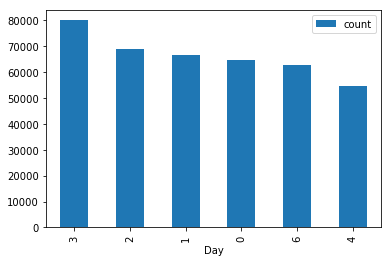

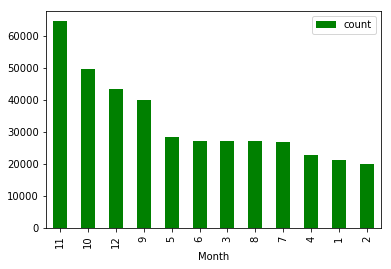

In [4]:
Day_stats=df.groupby('Day').describe()['CustomerID']['count']
Day_stats=Day_stats.reset_index().sort_values('count',ascending=False)

Month_stats=df.groupby('Month').describe()['CustomerID']['count']
Month_stats=Month_stats.reset_index().sort_values('count',ascending=False)

Year_stats=df.groupby('Year').describe()['CustomerID']['count']
Year_stats=Year_stats.reset_index().sort_values('count',ascending=False)

Day_stats.plot.bar(x='Day', y='count')
Month_stats.plot.bar(x='Month', y='count',color='green')

Lets have a look at customer visits by Country. As we will see below United Kingdom has fairly large number of customer base. Hence it won't be relevant to add country as a parameter in clustering.

In [5]:
Country_stats=df.groupby('Country').describe()['CustomerID']['count']
Country_stats=Country_stats.reset_index().sort_values('count',ascending=False)
Country_stats

,Country,count
35,United Kingdom,354321.0
14,Germany,9040.0
13,France,8341.0
10,EIRE,7236.0
30,Spain,2484.0
23,Netherlands,2359.0
3,Belgium,2031.0
32,Switzerland,1841.0
26,Portugal,1462.0
0,Australia,1182.0


Since Kmeans works only with continous numerical data type hence creating some variables which will encode data from categorial variables namely, CustomerID and StockCode. The following variables will be created.

TotalPrice: QuantityxUnitPrice

tot_diff_item: Total different items purchased by single customer.

times_item_purch: Number of times that particular(StockCode) item was purchased by different customers. 

spent_by_cust: Total amount spent by a customer for all items.

Also we will log transform all the continous data to reduce skew and make it more gaussian distributed. Incase a variable attains zero value Log(1+x) transformation will be applied. These transformations will also help in bringing data to relatively same case.

In [6]:
def getCountVar(compute_df, count_df, var_name):
        grouped_df = count_df.groupby(var_name)
        count_dict = {}
        for name, group in grouped_df:
                count_dict[name] = group.shape[0]

        count_list = []
        for index, row in compute_df.iterrows():
                name = row[var_name]
                count_list.append(count_dict.get(name, 0))
        return count_list

def getSumVar(compute_df, purchase_df, var_name,conti_var_name):
        grouped_df = purchase_df.groupby(var_name)
        sum_dict = {}
        for name, group in grouped_df:
                sum_dict[name] = np.sum(np.array(group[conti_var_name]))
                
        sum_list = []
        for index, row in compute_df.iterrows():
                name = row[var_name]
                sum_list.append(sum_dict.get(name,0))


        return  sum_list

df['TotalPrice']=df['Quantity']*df['UnitPrice']

# Total different items purchased by single customer
df['tot_diff_item']=    getCountVar(df,df,'CustomerID')  

#Number of times that particular(StockCode) item was purchased by different customers  
df['times_item_purch']=   getCountVar(df,df,'StockCode')  

# Total amount spent by customer for all items
df['spent_by_cust']= getSumVar(df,df,'CustomerID','TotalPrice')

# Log transforming spent_by_cust column to reduce skew and make it more gaussian distributed
df['spent_by_cust_log']=np.log(df['spent_by_cust'])

# Log transforming tot_diff_item column to reduce skew and make it more gaussian distributed

df['tot_diff_item_log']=np.log(df['tot_diff_item'])

# Log transforming times_item_purch column to reduce skew and make it more gaussian distributed

df['times_item_purch_log']=np.log(df['times_item_purch'])

# Log transforming Quantity column to reduce skew and make it more gaussian distributed

df['Quantity_log']=np.log(df['Quantity'])

# Log(1+x)  transforming UnitPrice column to reduce skew and make it more gaussian distributed also Log(1+x) because x takes value close to 0
df['TotalPrice_log']=np.log(1+df['TotalPrice'])

# Log(1+x)  transforming UnitPrice column to reduce skew and make it more gaussian distributed also Log(1+x) because x takes value close to 0
df['UnitPrice_log']=np.log(1+df['UnitPrice'])

cols_to_describe=['tot_diff_item_log','times_item_purch_log','spent_by_cust_log','Quantity_log','TotalPrice_log','UnitPrice_log']
df[cols_to_describe].describe()

,tot_diff_item_log,times_item_purch_log,spent_by_cust_log,Quantity_log,TotalPrice_log,UnitPrice_log
count,397884.000000,397884.000000,397884.000000,397884.000000,397884.000000,397884.000000
mean,5.379851,5.433838,7.995837,1.647959,2.454607,1.155088
std,1.386451,1.038367,1.490284,1.209286,1.020369,0.601605
min,0.000000,0.000000,1.321756,0.000000,0.001000,0.001000
25%,4.499810,4.836282,7.004855,0.693147,1.736951,0.810930
50%,5.303305,5.541264,7.884625,1.791759,2.549445,1.081805
75%,6.102559,6.175867,8.746362,2.484907,3.034953,1.558145
max,8.967887,7.618251,12.543280,11.302143,12.034517,9.005006


We will now decompose our data of continous variable into two dimensions using PCA, to visualize the clusters formed by Kmeans. We will tune the number of clusters parameter to find the optimum number of clusters based on elbow method. For more information: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

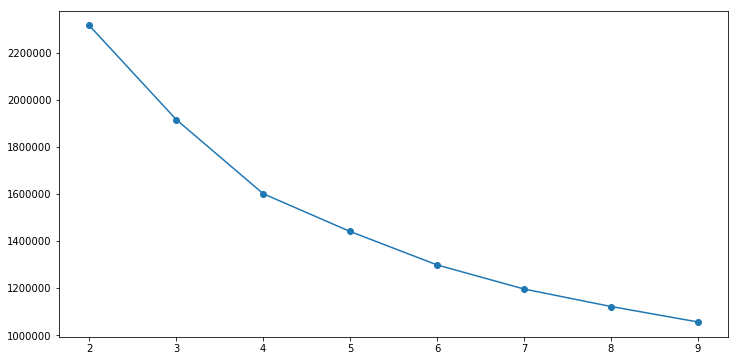

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

cols_to_use=['spent_by_cust_log',
             'tot_diff_item_log',
             'times_item_purch_log',
             'Quantity_log',
             'TotalPrice_log',
             'UnitPrice_log'
             ]
X=df[cols_to_use]

pca = PCA(n_components=2,random_state=8)
pca.fit(X)
X_pca = pca.transform(X)

cluster_range = range( 2, 10 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, random_state=10, n_jobs=-1 )
  clusters.fit( X )
  cluster_errors.append( clusters.inertia_ )

clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

As apparent from figure above 4 seems to be fair enough number of clusters. Let us now visualize cluster in two dimensions by pca vectors.

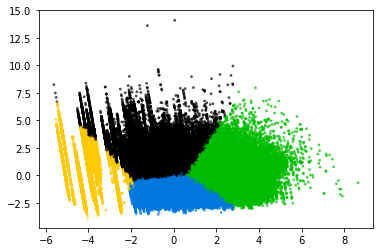

In [34]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=4, random_state=10, n_jobs=-1)
cluster_labels = clusterer.fit_predict(X)

colors = cm.spectral(cluster_labels.astype(float) / 4)
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

In [35]:
df['cluster_labels']=cluster_labels
df.head()

,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Day,Month,Year,TotalPrice,...,spent_by_cust_log,tot_diff_item_log,times_item_purch_log,Quantity_log,TotalPrice_log,UnitPrice_log,cluster_labels,mean_bycluster_spent_by_cust,mean_bycluster_tot_diff_item,mean_bycluster_times_item_purch
0,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2,12,2010,15.30,...,8.592525,5.693732,7.618251,1.791759,2.791165,1.266948,0,5116.487623,278.995563,408.86588
1,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,12,2010,20.34,...,8.592525,5.693732,5.572154,1.791759,3.060583,1.479329,0,5116.487623,278.995563,408.86588
2,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2,12,2010,22.00,...,8.592525,5.693732,5.497168,2.079442,3.135494,1.321756,0,5116.487623,278.995563,408.86588
3,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,12,2010,20.34,...,8.592525,5.693732,5.786897,1.791759,3.060583,1.479329,0,5116.487623,278.995563,408.86588
4,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2,12,2010,20.34,...,8.592525,5.693732,5.793014,1.791759,3.060583,1.479329,0,5116.487623,278.995563,408.86588


Lets get mean statistics per cluster namely mean total amount spent by customer, mean number of different items purchased by customer, and mean number of times that particular(StockCode) item was purchased by different customers.

In [36]:
def getMeanVar(compute_df, purchase_df, var_name,conti_var_name):
        grouped_df = purchase_df.groupby(var_name)
        sum_dict = {}
        for name, group in grouped_df:
                sum_dict[name] = np.mean(np.array(group[conti_var_name]))
                
        sum_list = []
        for index, row in compute_df.iterrows():
                name = row[var_name]
                sum_list.append(sum_dict.get(name,0))


        return  sum_list
    
df['mean_bycluster_spent_by_cust']= getMeanVar(df,df,'cluster_labels','spent_by_cust')
df['mean_bycluster_tot_diff_item']= getMeanVar(df,df,'cluster_labels','tot_diff_item')
df['mean_bycluster_times_item_purch']= getMeanVar(df,df,'cluster_labels','times_item_purch')

df1=df[['cluster_labels','mean_bycluster_spent_by_cust']]
df1=df1.drop_duplicates()

df2=df[['cluster_labels','mean_bycluster_tot_diff_item']]
df2=df2.drop_duplicates()

df3=df[['cluster_labels','mean_bycluster_times_item_purch']]
df3=df3.drop_duplicates()

Lets plot above dataframes to know whether some trend follows in cluster

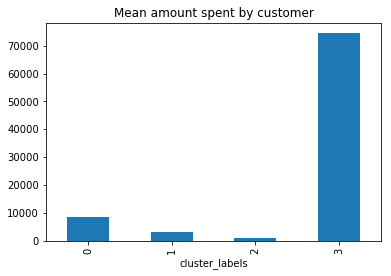

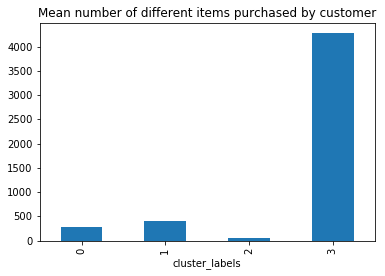

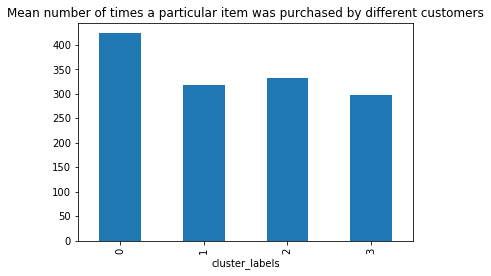

In [37]:
df1.plot.bar('cluster_labels','mean_bycluster_spent_by_cust',legend=False,title="Mean amount spent by customer")
df2.plot.bar('cluster_labels','mean_bycluster_tot_diff_item',legend=False,title="Mean number of different items purchased by customer")
df3.plot.bar('cluster_labels','mean_bycluster_times_item_purch',legend=False,title="Mean number of times a particular item was purchased by different customers")

The above findings show that cluster labeled as 3 contains high spending bracket of users. While cluster number 0 contains most popular items i.e items that are brought frequently.